In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import env
import acquire
import split_scale
#import features
import prep
#import exploration
#import feature_selection
#import model

### Acquisition and initial data exploration

In [334]:
df = acquire.prep_telco()

In [335]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [336]:
df.isnull().sum()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,...,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,...,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes


In [337]:
df.dtypes

customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
internet_service_type_id      int64
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
contract_type_id              int64
paperless_billing            object
payment_type_id               int64
monthly_charges             float64
total_charges                object
churn                        object
dtype: object

### Initial data prep

In [ ]:
df.total_charges = df.total_charges.replace(r'^\s*$', np.nan, regex=True)
df = df[df.total_charges.isna() == False]
df['total_charges'] = df['total_charges'].astype(float)
df.churn = df.churn == 'Yes'
df.senior_citizen = df.senior_citizen == 1
df['is_male'] = df.gender == 'Male'
df.paperless_billing = df.paperless_billing == 'Yes'

df['family'] = (df.partner == 'Yes') | (df.dependents == 'Yes')

df['phone'] = (df.phone_service == 'Yes') | (df.multiple_lines == 'Yes')
df['streaming'] = (df.streaming_tv == 'Yes') | (df.streaming_movies == 'Yes')
df['tech_protection'] = (df.device_protection == 'Yes') | (df.tech_support == 'Yes') | (df.online_backup == 'Yes') | (df.online_security == 'Yes')

### Initial Questions and exploration



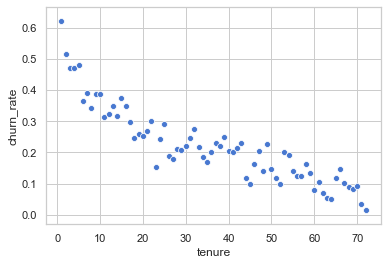

In [340]:
#tenure by churn rate
df_churned = df[['tenure','churn']].groupby('tenure').sum()
df_total = df[['tenure','churn']].groupby('tenure').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='tenure')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
ax = sns.scatterplot(x='tenure',y='churn_rate',data=df_churn_rate)


In [341]:
# churn by internet type. Fiber Optic customers churning at higher rate than DSL and no internet
df_churned = df[['internet_service_type_id','churn']].groupby('internet_service_type_id').sum()
df_total = df[['internet_service_type_id','churn']].groupby('internet_service_type_id').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='internet_service_type_id')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
df_churn_rate[['internet_service_type_id','churn_rate']]

,internet_service_type_id,churn_rate
0,1,0.189983
1,2,0.418928
2,3,0.074342


In [333]:
df.head()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,is_male,family,phone,streaming,tech_protection
0,False,9,1,2,True,2,65.6,593.30,False,False,True,True,True,True
1,False,9,1,1,False,2,59.9,542.40,False,True,False,True,True,False
2,False,4,2,1,True,1,73.9,280.85,True,True,False,True,False,True
3,True,13,2,1,True,1,98.0,1237.85,True,True,True,True,True,True
4,True,3,2,1,True,2,83.9,267.40,True,False,True,True,True,True


In [342]:
# churn by phone service. No difference in churn rate
df_churned = df[['phone','churn']].groupby('phone').sum()
df_total = df[['phone','churn']].groupby('phone').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='phone')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
df_churn_rate[['phone','churn_rate']]

,phone,churn_rate
0,False,0.250000
1,True,0.267475


In [ ]:
# churn by phone service. No difference in churn rate
df_churned = df[['phone','churn']].groupby('phone').sum()
df_total = df[['phone','churn']].groupby('phone').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='phone')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
df_churn_rate[['phone','churn_rate']]

### Data prep

- Converting churn and senior citizen to boolean.
- Combining partner and dependents into one variable called 'family' if either column is Yes.
- Combining phone_service and multiple_lines into one variable called phone if either column is Yes.



In [339]:
#converting to bool, dropping redundant columns
df.total_charges = df.total_charges.replace(r'^\s*$', np.nan, regex=True)
df = df[df.total_charges.isna() == False]
df['total_charges'] = df['total_charges'].astype(float)
df.churn = df.churn == 'Yes'
df.senior_citizen = df.senior_citizen == 1
df['is_male'] = df.gender == 'Male'
df.paperless_billing = df.paperless_billing == 'Yes'

df['family'] = (df.partner == 'Yes') | (df.dependents == 'Yes')

df['phone'] = (df.phone_service == 'Yes') | (df.multiple_lines == 'Yes')
df['streaming'] = (df.streaming_tv == 'Yes') | (df.streaming_movies == 'Yes')
df['tech_protection'] = (df.device_protection == 'Yes') | (df.tech_support == 'Yes') | (df.online_backup == 'Yes') | (df.online_security == 'Yes')

df.drop(['device_protection','tech_support','online_backup','online_security','streaming_tv','streaming_movies','gender','partner','dependents','customer_id','phone_service','multiple_lines'],axis=1,inplace=True)

In [294]:
len(df)

7032

#### Split and Scale

In [295]:
train, test = split_scale.split_my_data(df,train_ratio=.8,seed=123,stratify=None)

#### Create X and y train/test

In [296]:
X_train = train.drop(['churn'],axis=1)
y_train = train.churn
X_test = test.drop(['churn'],axis=1)
y_test = test.churn

#### Fit model to training data

In [297]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=123)

In [298]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [299]:
y_pred = clf.predict(X_train)

In [300]:
y_pred_prob = clf.predict_proba(X_train)
y_pred_prob

array([[0.76290323, 0.23709677],
       [0.98489752, 0.01510248],
       [0.76290323, 0.23709677],
       ...,
       [0.52147239, 0.47852761],
       [1.        , 0.        ],
       [0.88571429, 0.11428571]])

In [301]:
clf.score(X_train,y_train)

0.7925333333333333

In [302]:
confusion_matrix(y_train,y_pred)

array([[3711,  415],
       [ 752,  747]])

In [303]:
clf.score(X_test,y_test)

0.7910447761194029

In [304]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

       False       0.83      0.90      0.86      4126
        True       0.64      0.50      0.56      1499

    accuracy                           0.79      5625
   macro avg       0.74      0.70      0.71      5625
weighted avg       0.78      0.79      0.78      5625



In [305]:
import graphviz
from graphviz import Graph

dot_data = export_graphviz(clf,out_file=None)
graph = graphviz.Source(dot_data)

graph.render('telco_churn',view=True)

'telco_churn.pdf'

In [227]:
feature_importance = clf.feature_importances_.round(5)
feature_importance

array([0.     , 0.12247, 0.03081, 0.63098, 0.     , 0.01471, 0.16771,
       0.03332, 0.     , 0.     , 0.     , 0.     , 0.     ])

In [306]:
list_X = list(X_train.columns)

In [307]:
tree_scores = dict(zip(list_X,clf.feature_importances_.round(4)))

In [308]:
sorted(tree_scores.items(),key=lambda kv: kv[1],reverse=True)

[('contract_type_id', 0.631),
 ('monthly_charges', 0.1677),
 ('tenure', 0.1225),
 ('total_charges', 0.0333),
 ('internet_service_type_id', 0.0308),
 ('payment_type_id', 0.0147),
 ('senior_citizen', 0.0),
 ('paperless_billing', 0.0),
 ('is_male', 0.0),
 ('family', 0.0),
 ('phone', 0.0),
 ('streaming', 0.0),
 ('tech_protection', 0.0)]

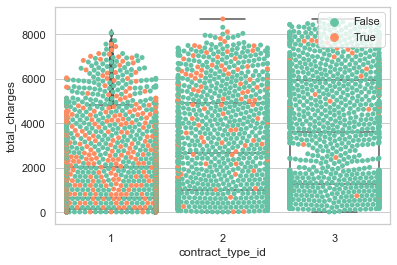

In [309]:
sns.swarmplot(x="contract_type_id", y="total_charges", data=train, hue="churn", palette="Set2")
ax = sns.boxplot(x="contract_type_id", y="total_charges", data=train,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})
plt.legend(loc=1)